# klasyczne i kwantowe sieci neuronowe 

## Wygeneruj klasyczną sieć neuronową dla funckji `sin(x)`


In [1]:
# import potrzebnych bibliotek 

import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output

torch.manual_seed(1234)

Wygenruj dane:

- korzystając z metody torch.linespace() wygenruj 500  punktów danych  dla zakresu (0,10) w tablicy `x`
- Ze względu, iz potrzebujemy 500 wierszy przypadków (a nie 500 zmiennych) jednowymiarowej tablicy zastosuj metodę view(-1,1)
- jako wynik `si` wygeneruj wartości funckji sin(x). Do zmiennej `y` zastosuj drobną zmianę dodając wartości losowe. 
- Analogicznie jak dla danych `x` pamiętaj o zmianie widoku : `view(-1,1)`


Ponizszy wykres wygeneruje Ci graficzną reprezentację danych

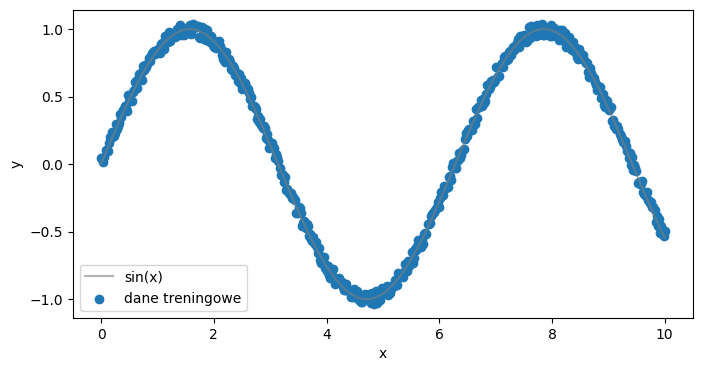

In [14]:
x = torch.linspace(0,10,500).view(-1,1)

si = torch.sin(x).view(-1,1)

y = si + 0.1*(torch.rand(500).view(-1,1)-0.5)


plt.figure(figsize=(8,4))
plt.plot(x, torch.sin(x).view(-1,1), color="tab:grey", alpha=0.6, label="sin(x)")
plt.scatter(x, y, label="dane treningowe")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

Korzystając z wartwy gęstej `torch.nn.Linear()`, oraz funkcji aktywacji (np. `torch.nn.ReLU(), torch.nn.Tanh()` i inne) utwórz sieć z kilkoma (przynajmniej jedną warstwą ukrytą) pozwalającą wygenerować model regresji.
Do definicji uzyj obiektu `Sequential()` - sprawdź w dokumentacji po co taki obiekt.

In [15]:
class SinusEstimator(torch.nn.Module):

    def __init__(self, N_INPUT: int, N_OUTPUT: int):
        super(SinusEstimator,self).__init__()
        self.layers = torch.nn.Sequential(
            # struktura Twojej sieci
            torch.nn.Linear(N_INPUT, N_OUTPUT),
        )


    def forward(self, x):
        x = self.layers(x)
        return x

Poniszy kod wytrenuje Twoją sieć:

In [16]:
############## 
# zdefiniuj obiekt modelu. 
model = SinusEstimator(1,1)
###########

learning_rate=0.001
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()

# dodatkowa funkcja - warto zrealizować
losses = []

def callback(model, loss):
    losses.append(loss.item())

    clear_output(wait=True)
    prediction = model(x).detach()
    plt.figure(figsize=(6,2.5))
    plt.plot(x[:,0].detach(), torch.sin(x)[:,0].detach(), label="Exact solution", color="tab:grey", alpha=0.6)
    plt.plot(x[:,0].detach(), prediction[:,0], label="Classical solution", color="tab:green")
    plt.title(f"Training step {len(losses)}")
    plt.legend()
    plt.show()

    plt.figure(figsize=(6,2.5))
    plt.title('Lossfn Visualised')
    plt.plot(losses)
    plt.show()


def train(X, Y, model, optimiser, epochs, lossfn, callback = None):
    for _ in range(epochs):
        model.train()
        prediction = model(X)
        loss = lossfn(prediction, Y)

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        model.eval()
        if callback != None:
            callback(model, loss)

Uruchom funkcję `train()` z odpowiednimi parametrami. 

- dane: `x`, `y`
- model sieci: `model`
- optymalizator: `optimiser`
- ilość epok: `500` (mozesz tez przetestowac najpierw 10 a potem np. 1000)
- funkcja straty: `criterion`
- callback: nasza zdefiniowana funkcja `callback`
 

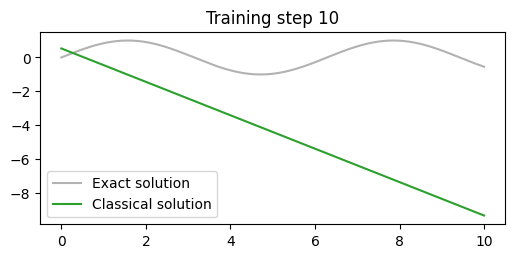

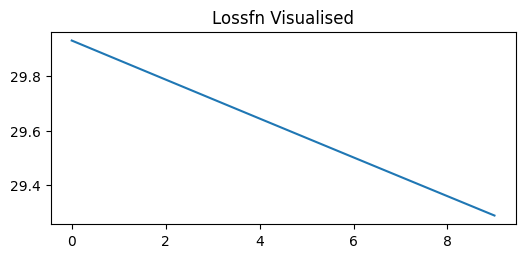

In [17]:
train(x,y,model,optimiser,10,criterion, callback)

spradz czy inna definicja funkcji kosztu  `special_loss_fn` usprawni wyniki sieci 

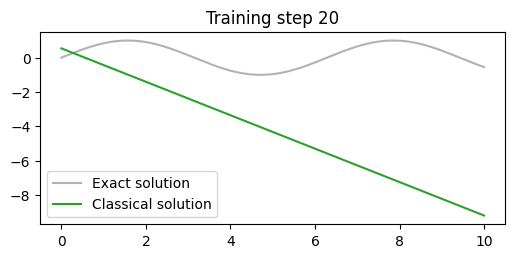

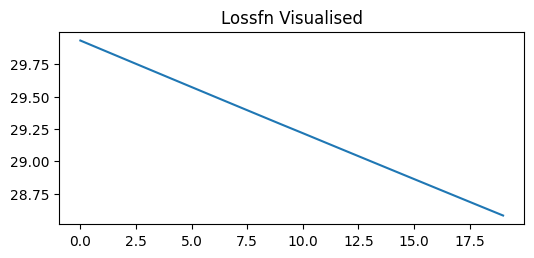

In [19]:
def mse(y, y_pred) -> torch.Tensor:
    return torch.mean((y-y_pred)**2)

def special_loss_fn(y, y_pred) -> torch.Tensor:
    return mse(y, y_pred) + torch.mean((y_pred - torch.sin(x))**2)

train(x,y,model,optimiser,10,special_loss_fn, callback)

## Kwantowa sieć neuronowa 

Zdefiniujmy nową strukturę siec - wymieniając warstę ukrytą na obwód kwantowy.
```python
class QN(nn.Module):
    '''Classical -> Quantum -> Classical'''

    def __init__(self, N_INPUT: int, N_OUTPUT: int, Q_NODE, N_QUBITS):
        super().__init__()

        self.layers = nn.Sequential(
            # input layer
            nn.Linear(N_INPUT, N_QUBITS),
            # 1st hidden layer as a quantum circuit
            Q_NODE,
            # output layer
            nn.Linear(N_QUBITS, N_OUTPUT)
        )
        

    def forward(self, x):
        return  self.layers(x)

```

Jak mozesz zauwazyc po warstwie wejsciowej umiescilismy obietk Q_NODE, którego funkcję podstawimy jako trzeci parametr naszej sieci.

Bez większego wchodzenia w definicję tego obiektu nasz obwód kwantowy musi pobrać dane z warstwy poprzedniej i wypuścić jakieś wyniki do warstwy wynikowej. 
Oczywiście taką operację musi realizować jakaś funkcja (obiekt) w pythonie.

In [23]:
class QN(torch.nn.Module):
    '''Classical -> Quantum -> Classical'''

    def __init__(self, N_INPUT: int, N_OUTPUT: int, Q_NODE, N_QUBITS):
        super().__init__()

        self.layers = troch.nn.Sequential(
            # input layer
            torch.nn.Linear(N_INPUT, N_QUBITS),
            # 1st hidden layer as a quantum circuit
            Q_NODE,
            # output layer
            torch.nn.Linear(N_QUBITS, N_OUTPUT)
        )
        

    def forward(self, x):
        return  self.layers(x)

In [ ]:
 # NASZ kwantowy PQC - parametryzowany obwód kwantowy dla jednej warstwy ukrytej
import pennylane as qml

n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]



n_layers = 5

weight_shapes = {"weights": (n_layers, n_qubits)}
qlayer = qml.qnn.TorchLayer(qnode, weight_shapes)

Uruchomienie sieci mozesz zrealizowac ponizszym kodem

In [ ]:
def mse(y, y_pred) -> torch.Tensor:
    # oblicz średnią z roznnicy y i y_pred podniesionej do kwadratu
    return ...


#########################
#   utworz zmienna qmodel z parametrami (1,1, qlayer, n_qubits)
#   Twoj kod
#  
qmodel = ...
#####

print(qmodel)

x = x.requires_grad_(True)
x_train = x.requires_grad_(True)

learning_rate=1e-3
optimiser = torch.optim.Adam(qmodel.parameters(), lr=learning_rate)

losses = []

def special_loss_fn(y, y_pred) -> torch.Tensor:
    return mse(y, y_pred) + torch.mean((y_pred - torch.sin(x))**2)
    

train(x_train, y, qmodel, optimiser, 500, special_loss_fn, callback)

Sprawdz wyniki kodem:

In [ ]:
def plot_result(x,y,x_data,y_data,yh, title=None):

    plt.figure(figsize=(8,4))
    plt.title(title)
    plt.plot(x,y, color="tab:grey", alpha=0.6, label="Exact solution")
    plt.plot(x,yh, color="tab:green", label="Neural network prediction")
    plt.scatter(x_data, y_data, alpha=0.3, label='Training data')
    l = plt.legend(loc='best')

plot_result(
    x.detach(),
    torch.sin(x).detach(),
    x.detach(),
    y.detach(),
    qmodel(x).detach(),
    title='Training of PINN'
    )

print(mse(qmodel(x), torch.sin(x)))